In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('../data/processed_data/merged_characteristics.csv')

#create mkt share data
blp_keys = ['market_ids', 'product_ids', 'firm_ids', 'shares', 'prices','demand_instruments0']

nonlinear_cols = ['csr_pay_94','EHBPercentTotalPremium']#,'SBCHavingDiabetesCopayment','SBCHavingaBabyCoinsurance']
#['act_value','csr_pay_94','csr_pay_87','SBCHavingDiabetesCopayment','SBCHavingaBabyCoinsurance']

linear_cols = [ 'act_value','MetalLevel_Platinum', 'MetalLevel_Silver']#
#['CompositeRatingOffered_No','MetalLevel_Silver','MetalLevel_Platinum',
# 'BeginPrimaryCareCostSharingAfterNumberOfVisits' , 'csr_tot', 'csr_tot_94', 'PlanType_Indemnity']            
#'CSRVariationTypeBinary','DentalOnlyPlan_No','CompositeRatingOffered_No',

firm_cols =  linear_cols+ nonlinear_cols    
mkt_cols = [ 'DP05_0015PE' ,'DP05_0069PE','S1701_C01_017E'] #'DP03_0001PE'


keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']

def create_blp_data(df):
    
    #create market data...
    df['shares'] = df['Ever Enrolled Count']/df['DP03_0095E']

    #add blp columns
    df['prices'] = df['PREMI27']
    df['product_ids'] = df['IssuerId'].astype(str) +  df['County'].astype(str) 
    df['market_ids'] = df['County']
    df['firm_ids'] = df['IssuerId']

    #demand_instrument0
    MktIds = np.array(pd.get_dummies(df['IssuerId']))
    MktIds2 = (MktIds.T).dot(MktIds)
    dummies_proj = MktIds.dot( np.linalg.inv( MktIds2 ) ).dot( MktIds.T )
    df['demand_instruments0'] = dummies_proj.dot(df['prices']) #average price across markets


    #fix problematic columns =
    df = df.rename(columns={'Average Monthly Advanced CSR Payment for Consumers with 94%':'csr_pay_94',
                      'Average Monthly Advanced CSR Payment for Consumers with 87%':'csr_pay_87',
                           'Total Number of Consumers':'csr_tot',
                            'Number of Consumers with CSR AV of 94%':'csr_tot_94'})

    #'DP05_0072PE', ,

    blp_data = df[blp_keys+linear_cols+nonlinear_cols+mkt_cols+['DP03_0095E']]


    #standardize the cols
    for col in firm_cols:
        #this line is causing a warning?
        blp_data[col] = blp_data[col]/blp_data[col].var()

    #zero shares are not okay?
    blp_data = blp_data[blp_data['shares']!=0]
    return blp_data,df
    
blp_data,df = create_blp_data(df)
blp_data  = blp_data.fillna(0)

print(blp_data['prices'].mean(),(1-blp_data['shares'].mean()))
print(df['Ever Enrolled Count'].sum())

213.01239952914435 0.9860024384331355
8185212.0


In [3]:
num_trials = 5
training_test = []

#initilize folds
np.random.seed()
kf = KFold(n_splits=num_trials,shuffle=True)
folds_indexes = kf.split(blp_data)

for fold_index in folds_indexes:
    np.random.seed()
    X_train = blp_data.iloc[fold_index[0]]
    X_test = blp_data.iloc[fold_index[1]]
    training_test.append( (X_train, X_test) )

In [4]:
mses = []
r2s = []
model_fit = None
pred_shares = None
true_shares = None
blp_pred = None

for i in range(num_trials):
    X_train, X_test = training_test[i]
    model = sm.Logit(X_train['shares'],
                     sm.add_constant(X_train[linear_cols+nonlinear_cols+mkt_cols+['demand_instruments0']]))
    model_fit = model.fit(disp=0)
    
    pred_shares = model_fit.predict(
        sm.add_constant(X_test[linear_cols+nonlinear_cols+mkt_cols+['demand_instruments0']]))
    
    #make predictions/figure out error
    blp_pred = pred_shares*X_test['DP03_0095E']
    true_shares = X_test['shares']*X_test['DP03_0095E']
    error = blp_pred - true_shares
    
    mse = float( (error**2).mean() )
    r2 = float( 1 - mse/true_shares.var() ) 
    mses.append(mse)
    r2s.append(r2)
    print('mse normalized trial ', i,':', r2, mse, float(true_shares.var()) )
    
mses,r2s = np.array(mses),np.array(r2s)
enrollments = blp_data['shares']*blp_data['DP03_0095E']
print( 'mse', np.array(mses).mean() ,'r2', 1 - float( mses.mean()/enrollments.var()) )
print( 'mse med', np.median(mses) ,'r2 med',r2s.reshape(num_trials,1)[mses == np.median(mses)][0,0] )

mse normalized trial  0 : -0.1146685713929616 40903479.13846074 36695642.26373147
mse normalized trial  1 : -0.19998218729417805 22338481.419367835 18615677.512462534
mse normalized trial  2 : -0.04440478442368079 24205657.292992283 23176509.389842894
mse normalized trial  3 : 0.22264092656237056 52195743.40867627 67144959.37875502
mse normalized trial  4 : 0.2576767100603069 23496449.978670187 31652583.580637835
mse 32627962.247633457 r2 0.0795532570658789
mse med 24205657.292992283 r2 med -0.04440478442368079


/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                           Logit Regression Results                           
Dep. Variable:                 shares   No. Observations:                 4280
Model:                          Logit   Df Residuals:                     4278
Method:                           MLE   Df Model:                            1
Date:                Tue, 26 Apr 2022   Pseudo R-squ.:                     inf
Time:                        16:37:24   Log-Likelihood:                -68.499
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.9729      0.334    -11.881      0.000      -4.628      -3.318
demand_instruments0    -0.0014      0.002     -0.895      0.371      -0.004       0.002


/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


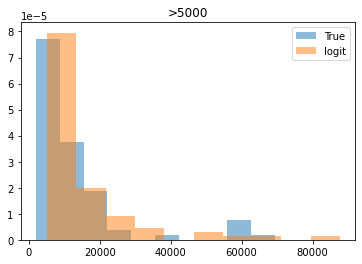

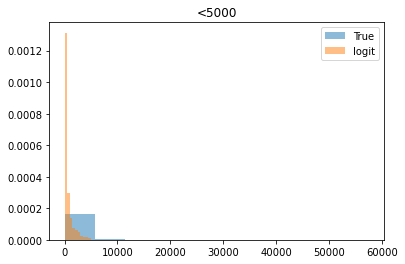

In [5]:
#print fit
print(model_fit.summary())

#evaluating model fit...
blp_pred = pred_shares*X_test['DP03_0095E']
true_shares = X_test['shares']*X_test['DP03_0095E']

split = 5000
plt.title('>'+str(split))
plt.hist(blp_pred[true_shares >=split],label='True',alpha=.5,density=True)
plt.hist(true_shares[true_shares >=split],label='logit',alpha = .5,density=True)
plt.legend()
plt.show()


plt.title('<'+str(split))
plt.hist(blp_pred[true_shares <=split],label='True',alpha=.5,density=True)
plt.hist(true_shares[true_shares <=split],label='logit',alpha = .5,density=True)
plt.legend()
plt.show()

In [6]:
def report_error(X_test,pred_shares):
    pred_shares = np.array(pred_shares.copy())
    X_test = X_test.copy()
    X_test['error'] =  ((X_test['shares']- pred_shares)*X_test['DP03_0095E'])**2
    X_test['pred'] = pred_shares*X_test['DP03_0095E']
    result = X_test.merge(df, how='inner',left_index=True, right_index=True,suffixes=('_x',''))    
    result = result.sort_values('error',ascending=False).head(50) 

    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby['count'] =result.groupby('State')['shares'].count()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

print(report_error(X_test,pred_shares))

               pred  Ever Enrolled Count      pred_var    enroll_var  count
State                                                                      
IL     39071.162855          9448.500000  42754.249680  12872.878952      2
AZ     37043.295100          6719.000000  33069.443726   5241.075462      2
TX     21719.073597          9311.600000  19374.894033  11751.908490     10
PA     21499.029815          8174.000000    438.819941   3882.016229      2
MI     17150.171160          1737.200000   4795.837698    983.290242      5
OH     16972.459230          5802.000000   1935.767077   6704.786499      2
FL     16754.390916         27767.888889  10137.962062  27663.316867      9
VA     12619.405976         21460.000000   7850.659360   8888.332240      2
WI     12426.456960         28963.000000           NaN           NaN      1
IN     12180.722578          3910.000000           NaN           NaN      1
MO     11488.560862         22955.000000           NaN           NaN      1
NJ     11250